# Project:  Identification of Grammatical Errors
## W266 -- Dec. 15, 2016
## Ross Katz, Drew Plant, Nina Kuklisova

## 1. Introduction to Grammatical Error Identification  
  
For this project we studied the ability of recurrent neural nets (RNNs) to identify grammatical errors from annotated corpuses of essays written in English by non-native English speakers.  For this study we attemped to use two corpora:

  *  The Cambridge Learner Corpus (CLC), specifically the [First Certificate in English (FCE) exams](http://ilexir.co.uk/applications/clc-fce-dataset/)
  *  Test data used in competitions as part of the [Conference on Computational Natural Language Learning - CoNLL](http://www.conll.org/)
  
We initially parsed the First Certificate in English (FCE) exams dataset:  
   * http://www.cup.cam.ac.uk/gb/elt/catalogue/subject/custom/item3646603/Cambridge-International-Corpus-Cambridge-Learner-Corpus/?site_locale=en_GB  
   
However we discovered that some of the annotations were a bit non-intuitive, and therefore opted to move to our other training corpus, the CoNLL-2013 dataset (see #3 below.)

This corpus was hand-annotated with five categories of error found in student essays, in order of frequency:
<img src="00000502.png">



As you can see above, each "MISTAKE" tag provides a starting paragraph and a series of offsets that indicate where the errors are located in the document. The mistake comes with a corresponding "TYPE" and "CORRECTION". For the purpose of this assignment, we ignore the correciton. In many cases, we see that multiple corrections could be applied to a single error. For example, if a student writes "is progressed well", one could either change "progressed" to "progressing" or one could correct "is" to "has". This distinction would be fundamental to any productionized system, but for now, we want to know whether our system can accurately identify and categorize the errors in questions. We will leave the problem of assigning the best possible correction to future work.

## 3. CoNLL-2013 analysis

### Imports

In [1]:
import nltk.corpus.reader.bnc
import nltk
import glove
import nltk
import numpy as np
import random
import tensorflow as tf
import time
import unittest
import word_stream
import word_utils
from __future__ import unicode_literals
import io
from textblob import Blobber
from textblob_aptagger import PerceptronTagger
from BeautifulSoup import BeautifulSoup
import re
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn import metrics

# Use BeautifulSoup to parse the CoNLL corpus
soup = BeautifulSoup(open('./release2.3.1/original/data_5types/official.5types.sgml'))
wrong_ps = soup.findAll('p')
# Review:  See that the first Text entry has been recovered:
wrong_ps[0].getText()

u'In modern digital world, electronic products are widely used in daily lives such as Smart phones, computers and etc. In work places, electronic devices such as computers are also inevitable to use to increase the productivity of the corporation. The convenience and high efficiency of using electronic products is being noticed by people worldwide. Some people started to think if electronic products can be further operated to more advanced utilization and replace human beings for better performances. Surveillance technology such as RFID (radio-frequency identification) is one type of examples that has currently been implemented. In this essay, I will discuss that if surveillance technology such as RFID (radio-frequency identification) should be used or not to track people. Personally, I agree to a large extent that surveillance technology such as RFID should be used to track people.'

### 3a. Explore the data with pandas  
  
It's informative to review our corpus and see a sampling of the types of errors that have been annotated.

In [2]:
docs = soup.findAll('doc')

mistakes = []

for i,doc in enumerate(docs):
  
  each_p = doc.findAll('p')
  each_mistake = doc.findAll('mistake')
  nid = doc['nid']
  for j, mistake in enumerate(each_mistake):
    try:
      new_record = {
        'doc_id': nid,
        'doc_mistake_num': j,
        'start_par': int(mistake['start_par']),
        'start_off': int(mistake['start_off']),
        'end_par': int(mistake['end_par']),
        'end_off': int(mistake['end_off']),
        'mistake_type': mistake.find('type').getText(),
        'word': each_p[int(mistake['start_par'])].getText()[int(mistake['start_off']):int(mistake['end_off'])],
        'correction': mistake.find('correction').getText()
      }
      mistakes.append(new_record)
    except:
      pass

mistake_df = pd.DataFrame(mistakes)
# mistake_df[:15]

  

In order to work with these mistakes in our Tensorflow RNN, we code each error type and create dictionaries to enable us to move from the names to codes or in reverse depending on the situation.

In [3]:
### CREATE ERROR CODES
error_list = list(mistake_df.mistake_type.unique())
print error_list 
### RESERVING 0 CODE FOR NON-ERROR
error_codes = [i+1 for i,code in enumerate(error_list)]
print error_codes

### CREATE DICT FOR LOOKUP CODE TO NAME
error_dict = dict(zip(error_codes, error_list))
print error_dict
### CREATE REVERSE DICT FOR LOOKUP NAME TO CODE
error_reverse_dict = dict(zip(error_list, error_codes))
print error_reverse_dict


[u'ArtOrDet', u'Nn', u'Prep', u'SVA', u'Vform', u'Spelling']
[1, 2, 3, 4, 5, 6]
{1: u'ArtOrDet', 2: u'Nn', 3: u'Prep', 4: u'SVA', 5: u'Vform', 6: u'Spelling'}
{u'ArtOrDet': 1, u'Nn': 2, u'SVA': 4, u'Vform': 5, u'Spelling': 6, u'Prep': 3}


As you can see below, the "Article or Determinant" error is by far the most common, with almost twice as many occcurences as the next most common error ("Noun Number"). These two categories are flagged more accurately by our models below, partially (we believe) a result of the relative sparsity of data for preposition, subject-verb agreement, and verb form errors. We address possible methods of improving the model to account for this sparsity below.

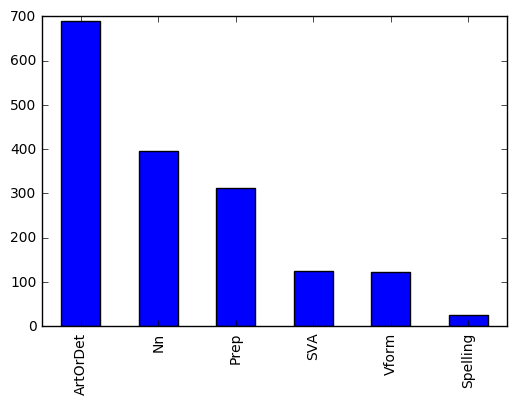

In [4]:
### Plot the number of mistakes of each type
%matplotlib inline
mistake_df.mistake_type.value_counts().plot(kind='bar')

At the suggestion of our instructors, we utilize an out-of-the-box part-of-speech tagger from TextBlob, [the TextBlob Perceptron Tagger](http://stevenloria.com/tutorial-state-of-the-art-part-of-speech-tagging-in-textblob/). We believe that parts of speech are valuable to the model, in that they help the RNN to identify what other features might be indicative of the presence of an error. Also, since the error-types are related to parts of speech, these should help with accurately identifying the error type as well. 

In [5]:
### POS TAGGER
tb = Blobber(pos_tagger=PerceptronTagger())
# train = list(train)
b1 = tb(wrong_ps[0].getText())
# print [x for x in b1.tags][:30]


### 4a. Pull out our word corpus and error labels from the CoNLL dataset

Below, we canonicalize the words and labels from the dataset, plugging the errors from the error tags (example above) and creating lists of words with mistakes, words without mistakes, binary error tags, and categorical error tags. 

In [6]:
# capture word probabilities
#
# It's necessary to divide each paragraph up into sections with no mistakes and into sections with mistakes...

# Define canonicalize
def canonicalize_words_and_labels(seq, label, errorLabel):
  # Insert <s> at start of sentence
  seq = re.sub(r'([.!?])',r' \1 ', seq.strip())
  
  # split off commas
  seq = re.sub(r',', r' , ', seq)
  
  # split off 4 digits from s
  seq = re.sub(r'(\d\d\d\d)s', r' \1 s ', seq)
  
  # split off "
  seq = re.sub(r'"', r' " ', seq)
  
  # split off %
  seq = re.sub(r'\%', ' % ', seq)
  
  # split off \( and \)
  seq = re.sub(r'([\(\)])', r' \1 ', seq)
  
  # convert can't to cant and won't to wont
  seq = re.sub(r"can't", r' cant ', seq)
  seq = re.sub(r"won't", r' wont ', seq)
  seq = re.sub(r"don't", r' dont ', seq)
  seq = re.sub(r"didn't", r' didnt ', seq)
  
  # Another other 't gets converted to not
  seq = re.sub(r"\'t\s", r' not ', seq)
  
  # split off 's
  seq = re.sub(r"\'s", r" 's ", seq)
  
  # split off ' that is not a 's
  seq = re.sub(r"\'([^s])", r" ' \1", seq)
  seq = re.sub(r"s'\s*", r"s ' ", seq)
  
  # split off ;
  seq = re.sub(r'(;)', r' \1 ', seq)
  
  # split at hyphen (-)
  seq = re.sub(r'(\-)', r' \1 ', seq)
  
  # split at colon
  seq = re.sub(r':', r' : ', seq)
  
  # split words by white space:
  splitWords = re.split(r'\s+', seq.strip())
  
  # lower-case all words
  splitWords = [Word.lower() for Word in splitWords]
  
  # Adjust labels, errors to have the same length as the number of words in the sequence...
  lenSeq = len(splitWords)
  seqLabels = [label] * lenSeq
  errorLabels = [errorLabel] * lenSeq
  return splitWords, seqLabels, errorLabels


wordCorpus = []         # list of every word in the corpus, splitting off punctuation as separate tokens
wordLabels = []         # list of Ylabels (0=="noErr", 1=="Err")
errorLabels = []        # list of error types (0-5)
correctWordCorpus = []  # corpus with only "good" and "corrected" words, should have no misspellings

docs = soup.findAll('doc')

mistakes = []

for i,doc in enumerate(docs):
  
  # Capture each mistake tag and each paragraph tag
  each_mistake = doc.findAll('mistake')

  # Re-package mistakes for more convenient indexing for paragraph words mistake.find('correction').getText()
  mistakeDict = { ( Dict['start_par'], Dict['start_off'] ) : ( Dict['end_par'], Dict['end_off'], Dict.find('correction').getText()) for Dict in each_mistake }
  mistake_labels = [mistake.find('type').getText() for mistake in each_mistake]
  mistake_count = 0
  each_p = doc.findAll('p')
  
  # Iterate over paragraphs
  for j, thisPara in enumerate(each_p):
    # print j
    # First paragraph offset
    Offset = 0
    paraLength = len(thisPara.getText())
    # Determine whether this paragraph has any mistakes
    if j not in [int(parNum[0]) for  parNum in mistakeDict.keys()]:  # if this paragraph has no errors...
      seq = thisPara.getText()
      # Canonicalize words for thisPara.getText()[:]
      myWords, myLabels, myErrors = canonicalize_words_and_labels(seq, label=0, errorLabel=0)
      wordCorpus.extend(myWords)
      wordLabels.extend(myLabels)
      errorLabels.extend(myErrors)
      correctWordCorpus.extend(myWords)
      
    else:
      # Initialize character index
      lastInd = 0
      matchParaErrors = (Key for Key in mistakeDict.keys() if int(Key[0]) == j)
      
      for errKey in sorted(matchParaErrors, key=lambda x:(int(x[1]))):
        startPar, startOff = (int(El) for El in errKey)
        endPar, endOff = ( int(El) for El in mistakeDict[errKey][0:2] )
        correctSeq = mistakeDict[errKey][2]
        
        # Error-checking -- I'm assuming that start_par == end_par
        if (not startPar == endPar):
          print "Error, starting paragraph #%d is not equal to end paragraph #%d" % (startPar, endPar)
          exit()
          
        # Debugging / checking
        # print "startPar %d, startOff %d, endPar %d, endOff %d" % (int(startPar), int(startOff), int(endPar), int(endOff))
        # Canonicalize words in range(lastInd:startOff) and assign each word label = 0
        if (lastInd < startOff):
          seq = thisPara.getText()[lastInd:startOff]
          myWords, myLabels, myErrors = canonicalize_words_and_labels(seq, label=0, errorLabel=0)
          wordCorpus.extend(myWords)
          wordLabels.extend(myLabels)
          errorLabels.extend(myErrors)
          correctWordCorpus.extend(myWords)
          
        # Canonicalize words in range(startOff:endOff) and assign each word label = 1
        if (startOff < paraLength):
          seq = thisPara.getText()[startOff:endOff]
          myWords, myLabels, myErrors = canonicalize_words_and_labels(seq, label=1, 
                                                      errorLabel=error_reverse_dict[mistake_labels[mistake_count]])
          wordCorpus.extend(myWords)
          wordLabels.extend(myLabels)
          errorLabels.extend(myErrors)
          myGoodWords, _, _ = canonicalize_words_and_labels(correctSeq, label=0, errorLabel=0)
          correctWordCorpus.extend(myGoodWords)
          mistake_count += 1
          
        lastInd = endOff
        
      # Finish up the paragraph
      if (paraLength >= lastInd):
        seq = thisPara.getText()[lastInd:paraLength]
        myWords, myLabels, myErrors = canonicalize_words_and_labels(seq, label=0, errorLabel=0)
        wordCorpus.extend(myWords)
        wordLabels.extend(myLabels) 
        errorLabels.extend(myErrors)
        correctWordCorpus.extend(myWords)

        
# Check 
print "Length of Corpus is %d words, %d binary labels, and %d error code labels" % (len(wordCorpus), len(wordLabels), len(errorLabels))



Length of Corpus is 29424 words, 29424 binary labels, and 29424 error code labels


In [7]:
print "Length of correct Word Corpus is %d words" % len(correctWordCorpus)
# print correctWordCorpus[:100]

Length of correct Word Corpus is 29584 words


## Create Part of Speech Tags for Corpus and Assign Codes

In order to use the POS tags, we need to assign them to the entire corpus and create codes for each tag.  As of now, we have 34 unique tags, including the "UNK" tag in situations (such as sentence start) where the word could not be tagged or does not have any English meaning.

In [8]:
### ASSIGN PART OF SPEECH TAGS WHERE POSSIBLE
### USE 'UNK' TOKEN IN SITUATIONS WHERE TAGGER IGNORED
posTags =[]

text = ' '.join(wordCorpus)
tagged = tb(text)
tag_list = [x[1] for x in tagged.tags]
word_list = [x[0].lower() for x in tagged.tags]
    
        
tags_used = 0
for w,word in enumerate(wordCorpus):
  try:
    index = word_list[tags_used:].index(word) + tags_used
    tag = tag_list[index]
    tags_used += 1
    posTags.append(tag)
  except:
    tag = 'UNK'
    posTags.append(tag)

### Assign Codes to Each Tag

In [10]:
# print "Length of POS Tags (should match length of wordCorpus above)"
# print len(posTags)
# print
# print "Unique Tags in Dataset"
# print sorted(set(posTags))
# print
# print "First 10 Tags"
# print posTags[:10]
# print


### CREATE ERROR CODES
pos_list = list(set(posTags))
pos_codes = [i for i,code in enumerate(pos_list)]

### CREATE DICT FOR LOOKUP CODE TO NAME
pos_dict = dict(zip(pos_codes, pos_list))
# print "Part of Speech Code to Label Lookup"
# print pos_dict
# print

### CREATE REVERSE DICT FOR LOOKUP NAME TO CODE
pos_reverse_dict = dict(zip(pos_list, pos_codes))
# print "Part of Speech Label to Code Lookup"
# print pos_reverse_dict

### Create list of pos numerical IDs for each word in our Corpus
posIDs = [ pos_reverse_dict[POS] for POS in posTags]


### 4b. Load our corpus and create training- / test- words/labels

In [11]:
import vocabulary; reload(vocabulary)
import utils; reload(utils)
import itertools
import rnnlm; reload(rnnlm)


# Word processing functions
def c_canonicalize_digits(word):
  if any([c.isalpha() for c in word]): return word
  word = re.sub("\d", "DG", word)
  if word.startswith("DG"):
    word = word.replace(",", "") # remove thousands separator
  return word

def c_canonicalize_word(word, wordset=None, digits=True):
  word = word.lower()
  if digits:
    if (wordset != None) and (word in wordset): return word
    word = c_canonicalize_digits(word) # try to canonicalize numbers
  if (wordset == None) or (word in wordset): return word
  else: return "<unk>" # unknown token

def c_canonicalize_words(words, **kw):
  return [c_canonicalize_word(word, **kw) for word in words]


def c_build_vocab(corpus, V=10000):
    # token_feed = (utils.canonicalize_word(w) for w in corpus.words())
    # token_feed = (utils.canonicalize_word(w) for w in corpus)
    vocab = vocabulary.Vocabulary(corpus, size=V)
    return vocab

def c_get_sents(corpus):
  '''Simply return the already-created list of list of sentences for our corpus...'''
  # Sentences = re.findall(r'[^.?!]+[.?!]', ' '.join(corpus))
  # Now split each sentence in Sentences into a list of tokens
  # Sentences = [Sent.split() for Sent in Sentences]
  # Sentences = np.array(Sentences, dtype=object)
  return sentsCorpus
  
def c_get_train_test_sents(Sents, Labels, POS, ErrLabels, split=0.8, shuffle=0):
    """Get train and test sentences."""
    #
    # Create list of sentence lists from corpus
    sentences = np.array(Sents)
    labels = np.array(Labels)
    posIDs = np.array(POS)
    errIDs = np.array(ErrLabels)
    
    # In order to work with shuffling, tuple-ize the lists within the list of lists
    listOfTupes = zip(sentences, labels, posIDs, errIDs)
    

    fmt = (len(sentences), sum(map(len, sentences)))
    print "Loaded %d sentences (%g tokens)" % fmt

    if shuffle:
        rng = np.random.RandomState(shuffle)
        rng.shuffle(listOfTupes)  # in-place
    # unroll...
    unZipped = zip(*listOfTupes)
    sentences = unZipped[0]
    labels = unZipped[1]
    posIDs = unZipped[2]
    errIDs = unZipped[3]

    train_frac = split
    split_idx = int(train_frac * len(sentences))
    train_sentences = sentences[:split_idx]
    test_sentences = sentences[split_idx:]
    train_labels = labels[:split_idx]
    test_labels = labels[split_idx:]
    train_pos = posIDs[:split_idx]
    test_pos = posIDs[split_idx:]
    train_errIDs = errIDs[:split_idx]
    test_errIDs = errIDs[split_idx:]
    #
    fmt = (len(train_sentences), sum(map(len, train_sentences)))
    print "Training set: %d sentences (%d tokens)" % fmt
    fmt = (len(test_sentences), sum(map(len, test_sentences)))
    print "Test set: %d sentences (%d tokens)" % fmt
    print
    #
    fmt = (len(train_labels), sum(map(len, train_labels)))
    print "Training set: %d labels (%d tokens)" % fmt
    fmt = (len(test_labels), sum(map(len, test_labels)))
    print "Test set: %d labels (%d tokens)" % fmt
    print
    #
    fmt = (len(train_pos), sum(map(len, train_pos)))
    print "Training set: %d POS labels (%d tokens)" % fmt
    fmt = (len(test_pos), sum(map(len, test_pos)))
    print "Test set: %d POS labels (%d tokens)" % fmt
    print
    #
    fmt = (len(train_errIDs), sum(map(len, train_errIDs)))
    print "Training set: %d error ID labels (%d tokens)" % fmt
    fmt = (len(test_errIDs), sum(map(len, test_errIDs)))
    print "Test set: %d error ID labels labels (%d tokens)" % fmt
    print
    #
    return train_sentences, test_sentences, train_labels, test_labels, train_pos, test_pos, train_errIDs, test_errIDs

def c_flatten(list_of_lists):
  """Flatten a list-of-lists into a single list."""
  return list(itertools.chain.from_iterable(list_of_lists))

def c_preprocess_sentences(sentences, vocab):
  # words = ["<s>"] + utils_flatten(s + ["<s>"] for s in sentences)
  words = c_flatten(s for s in sentences)
  # words = [c_canonicalize_word(w, wordset=vocab.word_to_id) for w in words]
  return np.array(vocab.words_to_ids(words))

def c_preprocess_labels(Labels):
  flatLabels = c_flatten(Label for Label in Labels)
  # words = [utils_canonicalize_word(w, wordset=vocab.word_to_id) for w in words]
  return np.array(flatLabels)

def c_load_corpus(corpus, split=0.8, V=10000, shuffle=0):
  """Load a named corpus and split train/test along sentences."""
  # corpus = inCorpus
  vocab = c_build_vocab(corpus, V)
  train_sentences, test_sentences = c_get_train_test_sents(corpus, split, shuffle)
  train_ids = c_preprocess_sentences(train_sentences, vocab)
  test_ids = c_preprocess_sentences(test_sentences, vocab)
  return vocab, train_ids, test_ids

  
def splitby(pattern, sentenceStack):
  """
  Split by a pattern function 
  This is much like re.split() regular expression function but can operate on other objects besides input strings.
    pattern:        a function applied to each element in the stack, xs.
    sentenceStack:  the stack list of (word,label) tuples in our corpus.
  """
  
  currentSentence = []
  for Tuple in sentenceStack:
    # If Tuple word is not an end of sentence punctuation,
    if pattern(Tuple):
      # Append the tuple to the current sentence
      currentSentence.append(Tuple)
    else:
      break
      
  return currentSentence, sentenceStack[len(currentSentence):] 
  
  
def ispunct(x):
  return x == "." or x == "!" or x == "?"


def sentences(xs):
  results = []
  
  # Iterate through corpus tuples ('word', 0) tuple-by-tuple until all sentences are exhausted.
  while True:
    # Spit out next sentence in xs and new xs with sentence's words popped off
    sentence, xs = splitby(lambda x: not ispunct(x[0]), xs)
    
    # Pop off top (punctuation character) from corpus stack and put onto the end of the current sentence to which
    # ...it belongs
    if len(xs) >= 1:
      sentence.append(xs[0])
      xs = xs[1:]
    
    # Add the current sentence (list of (word, label) tuples) to the results list
    results.append(sentence)
    
    # Exit while loop when sentence stack is empty.
    if not xs:
      break
  
  # Return the results list of lists split by punctuation
  return results  
  

def unzip(xs):
  # unzip leverages zip() on a list of tuples, resulting in a list of two lists:
  # ...list( [ tuple1[0], tuple2[0],...],
  #          [ tuple1[1], tuple2[1]],...])
  return zip(*xs)

### ASSIGN SIZE OF VOCABULARY
V = 10000
# vocab, train_ids, test_ids = load_corpus("brown", split=0.8, V=V, shuffle=42)

# Construct vocabulary, train_words, test_words, train_labels, test_labels

# Recall:
## wordCorpus = list of words
## wordLabels = list of labels

# Create tuples of word strings, wordLabels (0/1 for nonError/Error), POS, and ErrorType
corpusTuples = zip(wordCorpus, wordLabels, posIDs, errorLabels)
ss = sentences(corpusTuples)

# print ss

sentsCorpus = [] # List of lists divided by sentence endings [.!?]
sentsLabels = [] # List of lists of labels matching sentsCorpus
sentsPOS = [] # List of lists of POS matching words in sentsCorpus
sentsErrLabels = [] # List of lists of types of errors matching words in sentsCorpus

for sentence in ss:
  unzipped = unzip(sentence)
  sentsCorpus.append(list(unzipped[0]))
  sentsLabels.append(list(unzipped[1]))
  sentsPOS.append(list(unzipped[2]))
  sentsErrLabels.append(list(unzipped[3]))


V = 10000

# Build vocabulary
vocab = c_build_vocab(correctWordCorpus, V=V)

type(vocab)

# Generate training and test words and labels
trainWords, testWords, trainListY, testListY, trainPOS, testPOS, trainErrTypes, testErrTypes = c_get_train_test_sents(Sents=sentsCorpus, 
                                                                                                              Labels=sentsLabels, 
                                                                                                              POS=sentsPOS, 
                                                                                                              ErrLabels=sentsErrLabels, 
                                                                                                              split=0.8, 
                                                                                                              shuffle=42)


Loaded 1379 sentences (29424 tokens)
Training set: 1103 sentences (23523 tokens)
Test set: 276 sentences (5901 tokens)

Training set: 1103 labels (23523 tokens)
Test set: 276 labels (5901 tokens)

Training set: 1103 POS labels (23523 tokens)
Test set: 276 POS labels (5901 tokens)

Training set: 1103 error ID labels (23523 tokens)
Test set: 276 error ID labels labels (5901 tokens)



In [12]:
# # Check
# print "first sentence in training dataset"
# print len(trainWords[0])
# print "first setence in traning labels"
# print len(trainListY[0])

# Convert trainWords, testWords to ids:
train_ids = c_preprocess_sentences(trainWords, vocab)
test_ids = c_preprocess_sentences(testWords, vocab)
all_ids = c_preprocess_sentences(np.array([ wordCorpus ]) , vocab)
# print len(train_ids)
# print len(test_ids)

trainY = c_preprocess_labels(trainListY)
testY = c_preprocess_labels(testListY)

train_posids = c_preprocess_labels(trainPOS)
test_posids = c_preprocess_labels(testPOS)

# print
# print
# print "First sentence in our list of sentences:  "
# print trainWords[:1]
# print
# print "First 20 of our word id's:"
# print train_ids[:20]
# print
# print "First 20 of our error labels"
# print "   ( y=0:  no grammar error )"
# print "   ( y=1:  grammar error )"
# print trainY[:20]
# print
# print "Proportion of train words that are errors: %0.4f" % np.mean(trainY*1.00)
# print "Proportion of test words that are errors: %0.4f" % np.mean(testY*1.00)
# print 


## 6 Use Glove Embeddings instead of learning embeddings

### 6.0 Load Glove Embeddings

In [13]:
def loadGloveModel(gloveFile):
    print "Loading Glove Model"
    f = open(gloveFile,'r')
    model = {}
    for line in f:
        splitLine = line.split()
        word = splitLine[0]
        embedding = [float(val) for val in splitLine[1:]]
        model[word] = embedding
    print "Done.",len(model)," words loaded!"
    return model

glove_embeddings = loadGloveModel('glove.6B.300d.txt')

Loading Glove Model
Done. 400000  words loaded!


### 6.1 Create Embeddings Matrix from the set of all words in our corpus

In [16]:
# glove_embeddings is a dict

# print "Length of unique words in corpus:  %d" % len(set(wordCorpus)) # Number of unique words
# print
# print "Length of unique word IDs in corpus:  %d" % (len(set(correctWordCorpus))) # Number of unique words
# print "Maximum wordID:  %d"  % max( set(all_ids))
                                                

# As GloVe has no "unknown" embedding, calculate it as point-wise average of all glove vectors:
allGloveVecs = glove_embeddings.values()
# Note doing the easier thing of zip(*allGloveVes) crashes python!
unkVector=[]
# Iterate over all 300 embedding components for all words in GloVe to get unknown...
for compIndex in range(0,300):
  WordVec = [Vec[compIndex] for Vec in allGloveVecs]
  meanVal = np.mean(WordVec)
  unkVector.append(meanVal)

# Construct a set of unique words in correctWordCorpus (the corrected corpus)
uniqCWords = list(set( correctWordCorpus ))
uniqCIds = vocab.words_to_ids(uniqCWords)
  
# Construct a set of unique tuples ( word, wordID )
reverseWordIdTups = dict( zip( uniqCIds, uniqCWords ) )
                                                    

# Iterate over word tuples to construct wordID table:
## pre-allocate gloveArray 1st row for 'unk' embedding
unknownWord = '<unk>'
wordsNotInGlove=0
# Initialize 0th row of gloveArray with <unk> vector just computed:
gloveArray = np.array( [unkVector] )  # A 2-dimensional array.
for rowNum in range(1, 1 + max( reverseWordIdTups.keys() )):
  gloveKey = reverseWordIdTups.get( rowNum, unknownWord  )
  unknownEmbedding = unkVector
  rowEmb = glove_embeddings.get( gloveKey, unknownEmbedding) # Assign <unk> vector if id is missing
  if rowEmb == unknownEmbedding:
    wordsNotInGlove+=1
#     print gloveKey
  gloveArray = np.append(gloveArray, [rowEmb], axis=0)
  
print "There are %d words missing from GloVe." % wordsNotInGlove

There are 9 words missing from GloVe.


## 8 Working with POS in LSTM RNN

### 8.1 Wire up a new RNN with an additional embedding for POS

In [14]:
# Fresh imports
import utils_pos; reload(utils_pos)
import rnnlm_glove_pos; reload(rnnlm_glove_pos)
import os, sys, re, json, time, shutil

# Clear old log directory
shutil.rmtree("tf_summaries", ignore_errors=True)


with tf.Graph().as_default():
  tf.set_random_seed(42)

  lm = rnnlm.RNNLM(V=10000, H=200, num_layers=2)
  lm.BuildCoreGraph()
  lm.BuildTrainGraph()
  lm.BuildSamplerGraph()
  summary_writer = tf.train.SummaryWriter("tf_summaries",
                                          tf.get_default_graph())

### 8.2 Load new *run_epoch_pos* and *utils_pos* to include POS as inputs

In [17]:
# Load a modified version of run_epoch
import rnnlm_glove_pos; reload(rnnlm_glove_pos)
import utils_pos; reload(utils_pos)
import tensorflow as tf

# Define our model parameters
# Training parameters
max_time = 20
batch_size = 50
learning_rate = 0.007
keep_prob = .88
num_epochs = 10

# Model parameters
model_params = dict(V=len(gloveArray), 
                    Hword=300, 
                    Hpos=10,
                    num_layers=1)

with tf.Graph().as_default(), tf.Session() as session:
  # Seed RNG for repeatability
  tf.set_random_seed(42)
  
  # Declare the tensorflow model
  with tf.variable_scope("model", reuse=None):
    lm = rnnlm_glove_pos.RNNLM_gpos(**model_params)
    lm.BuildCoreGraph()
    lm.BuildTrainGraph()
  
  _ = session.run(tf.initialize_all_variables(), 
                                 feed_dict = {lm.gloveTable_:gloveArray} )
  # Further, initialize the precision operation tensor
  # outputs = session.run( lm.reshape_y_label_, feed_dict = { lm.y_label_:np.zeros((2*batch_size, max_time, 2))
  #                          } )
  
  # Drew debug
  for epoch in xrange(1,num_epochs+1):
    t0_epoch = time.time()
    # Drew, modified batch_generator to add trainY as a target
    bi = utils_pos.batch_generator_pos(train_ids, train_posids, trainY, batch_size, max_time)
    print "[epoch %d] Starting epoch %d" % (epoch, epoch)
    #### YOUR CODE HERE ####
   
    
    # Run a training epoch.
    utils_pos.run_epoch_pos(lm, session, bi, train=True, keep_prob=keep_prob, learning_rate=learning_rate)
    
    #### END(YOUR CODE) ####
    print "[epoch %d] Completed in %s" % (epoch, utils.pretty_timedelta(since=t0_epoch))
    
    ##
    # score_dataset will run a forward pass over the entire dataset
    # and report perplexity scores. This can be slow (around 1/2 to 
    # 1/4 as long as a full epoch), so you may want to comment it out
    # to speed up training on a slow machine. Be sure to run it at the 
    # end to evaluate your score.
    print ("[epoch %d]" % epoch),
    lmYs_train, lmYHats_train = utils_pos.score_dataset_pos(lm, session, train_ids, train_posids, trainY, name="Train set")
    print ("[epoch %d]" % epoch),
    lmYs_test, lmYHats_test = utils_pos.score_dataset_pos(lm, session, test_ids, test_posids, testY, name="Test set")
    print ""
  # see if embeddings changed...
  print lm.embeddings_.eval()[:4]

Instructions for updating:
Use `tf.global_variables_initializer` instead.
[epoch 1] Starting epoch 1
[epoch 1] Completed in 0:00:04
[epoch 1] Train set: avg. loss: 0.207  (perplexity: 1.23)
[epoch 1] Test set: avg. loss: 0.189  (perplexity: 1.21)

[epoch 2] Starting epoch 2
[epoch 2] Completed in 0:00:04
[epoch 2] Train set: avg. loss: 0.199  (perplexity: 1.22)
[epoch 2] Test set: avg. loss: 0.181  (perplexity: 1.20)

[epoch 3] Starting epoch 3
[epoch 3] Completed in 0:00:04
[epoch 3] Train set: avg. loss: 0.193  (perplexity: 1.21)
[epoch 3] Test set: avg. loss: 0.177  (perplexity: 1.19)

[epoch 4] Starting epoch 4
[epoch 4] Completed in 0:00:04
[epoch 4] Train set: avg. loss: 0.187  (perplexity: 1.21)
[epoch 4] Test set: avg. loss: 0.173  (perplexity: 1.19)

[epoch 5] Starting epoch 5
[epoch 5] Completed in 0:00:04
[epoch 5] Train set: avg. loss: 0.182  (perplexity: 1.20)
[epoch 5] Test set: avg. loss: 0.170  (perplexity: 1.18)

[epoch 6] Starting epoch 6
[epoch 6] Completed in 0:00:0

In [18]:
def score_dataset(lm, session, ids, Ylabels, name="Data"):
  """
  score_dataset uses:
     test_ids:  test words
     testY:     target labels, where good = 0 | bad = 1.
     yHat:      tf output prediction for good = 0 | bad = 1.

  It produces Correct = ( test_ids == testY )
     
  and calculates:
       Precision = Count( yHat == testY == 1 ) / Count( yHat == 1 )
       Recall = Count( yHat == testY == 1 ) / Count( testY == 1 )
  """
  bi = utils.batch_generator(ids, Ylabels, batch_size=100, max_time=100)
  cost, y_2wide_Hats, y_2wide_Labels = run_epoch(lm, session, bi, 
                              learning_rate=1.0, keep_prob=1.0, 
                              train=False, verbose=False, tick_s=3600)
  # print "%s: precision: %.03f  avg. loss: %.03f  (perplexity: %.02f)" % (name, precision, cost, np.exp(cost))
  print "%s: avg. loss: %.03f  (perplexity: %.02f)" % (name, cost, np.exp(cost))

  return y_2wide_Labels, y_2wide_Hats
  

### 5f. Evaluate precision, recall, F1 Accuracy, and ROC AUC of our baseline LSTM RNN

In [21]:
from sklearn.metrics import precision_recall_curve
import pylab as pl

# Extract the "true" labels and probabilities
trueTrainLabel = [ ylabelLM[1] for ylabelLM in lmYs_train ] 
trueTrainProb = [ yHatLM[1] for yHatLM in lmYHats_train ] 

trueTestLabel = [ ylabelLM[1] for ylabelLM in lmYs_test ] 
trueTestProb = [ yHatLM[1] for yHatLM in lmYHats_test ] 

def calcPrecision( Labels, Probs, Threshold, dataType = "Training"):
  Tups = zip( Labels, Probs)
  numer = len( [ predTrue for predTrue in Tups if ( predTrue[1] > Threshold and predTrue[0] == 1 )  ] ) # True positives!
  denomP = len( [ predTrue for predTrue in Tups if predTrue[1] > Threshold   ] ) # All positives!
  denomR = len( [ predTrue for predTrue in Tups if  predTrue[0] == 1   ] ) # All positives!
  
  # numer = len( [ predTrue in Tups if  predTrue[1] > Threshold  ] ) # True positives!
  Prec = float(numer)/float(denomP)
  Rec = float(numer)/float(denomR)
  F2 = 2 * (Prec * Rec)/(Prec + Rec)
  print "Setting threshold to %f with %s data:" % ( Threshold, dataType)
  print "     precision is %f" % ( Prec )
  print "     recall is %f" % ( Rec )
  print "     F2 is %f" % ( F2 )
  print
  
for threshold in [.08,.1,.12,.14,.16,.17,.18,.19,.2,.21,.22]:
  calcPrecision( trueTrainLabel, trueTrainProb, threshold, dataType = "Training" )
  calcPrecision( trueTestLabel, trueTestProb, threshold, dataType = "Test" )
  
def plot_precision_recall(lines, fname):
    pl.clf()

    for precision, recall, label in lines:
        pl.plot(recall, precision, label=label)
    pl.xlabel('Recall')
    pl.ylabel('Precision')
    pl.ylim([0.0, 1.05])
    pl.xlim([0.0, 1.0])
    pl.title('Precision-Recall')
    pl.legend(loc="upper right")
    pl.savefig(fname)

# print lmYs_train[1][1] == 1
# yLabelTrue in ( ylabelLM in lmYs_train if(lambda y: y[1] == 1 )   )
# Num = len( [yLabelTrue in ( ylabelLM in lmYs_train if(lambda y: y[1] == 1. )   )   )
# x[1],y[1] in ( x,y in (zip(lmYs_train[(range(30))],lmYHats_train[(range(30))]) )

Setting threshold to 0.080000 with Training data:
     precision is 0.223732
     recall is 0.770774
     F2 is 0.346798

Setting threshold to 0.080000 with Test data:
     precision is 0.159216
     recall is 0.632399
     F2 is 0.254386

Setting threshold to 0.100000 with Training data:
     precision is 0.255826
     recall is 0.707736
     F2 is 0.375808

Setting threshold to 0.100000 with Test data:
     precision is 0.188109
     recall is 0.601246
     F2 is 0.286563

Setting threshold to 0.120000 with Training data:
     precision is 0.289635
     recall is 0.655205
     F2 is 0.401698

Setting threshold to 0.120000 with Test data:
     precision is 0.216766
     recall is 0.563863
     F2 is 0.313149

Setting threshold to 0.140000 with Training data:
     precision is 0.320599
     recall is 0.613181
     F2 is 0.421053

Setting threshold to 0.140000 with Test data:
     precision is 0.241429
     recall is 0.526480
     F2 is 0.331048

Setting threshold to 0.160000 with Train

Train P-R Curve


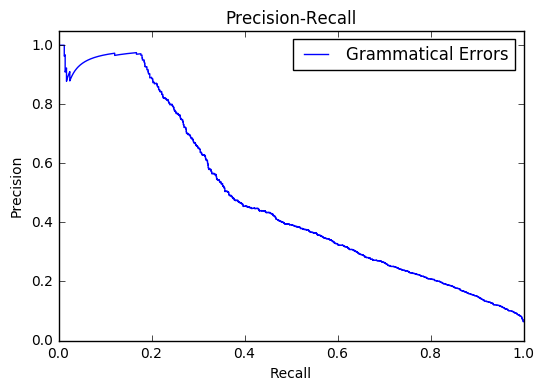

In [22]:
print "Train P-R Curve"
lines = []
precision, recall, thresholds = precision_recall_curve(trueTrainLabel, trueTrainProb)
lines.append( (precision, recall, "Grammatical Errors") )
png_fname = 'train_pr_curve.png'
plot_precision_recall(lines, png_fname)

Test P-R Curve


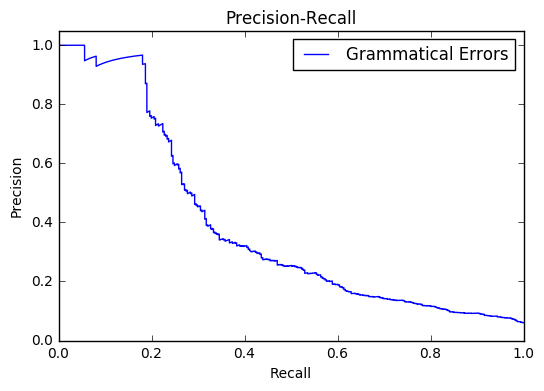

In [23]:
print "Test P-R Curve"
lines = []
precision, recall, thresholds = precision_recall_curve(trueTestLabel, trueTestProb)
lines.append( (precision, recall, "Grammatical Errors") )
png_fname = 'test_pr_curve.png'
plot_precision_recall(lines, png_fname)

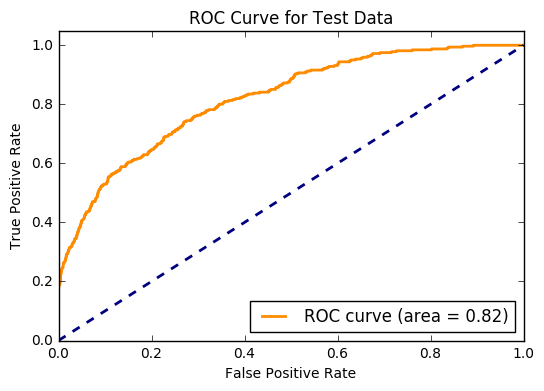

In [24]:
fpr, tpr, thresholds = metrics.roc_curve(trueTestLabel, trueTestProb)
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC Curve for Test Data')
plt.show()

## Exploring Performance on Different Error Types

Based on the error analysis below, it appears that we are better at predicting article or noun errors than we are errors of preposition usage (Prep), subject-verb agreement (SVA), and verb form (VForm). In particular, VForm has given our model substantial trouble. As mentioned above, this may be related to the quantity of the first two error types being higher than the remaining three. It also may be that we do not yet have features that adequately capture the dynamics underlying the preposition or verb errors that students typically make. We explore these dynamics at multiple threshold levels in order to understand the relationship between false positives (errors we tag wrongly, when they are actually not mistakes) and false negatives (actual errors that our model misses).

Afterward, we take a moderate threshold value of .13 to create a dataframe that will allow us to continue our review of examples our model missed. 

In [25]:
test_error_list = list(testErrTypes)
flat_test_errors = [word for sentence in test_error_list for word in sentence][:(len(trueTestProb)/2)]
flat_test_probs = trueTestProb[:(len(trueTestProb)/2)]
flat_test_words = [word for sentence in testWords for word in sentence][:(len(trueTestProb)/2)]

# print len(flat_test_errors)
# print len(flat_test_probs)


In [26]:

# print np.mean(flat_test_probs), np.median(flat_test_probs)
# print np.mean(trueTestLabel), np.sum(trueTestLabel)

for threshold in [.03, .07, .1, .13, .16, .2]:
# threshold = .13
  flat_test_array = np.array(flat_test_probs)
  over_threshold = flat_test_array >= threshold
  under_threshold = flat_test_array < threshold

  actual_error = np.array(flat_test_errors) > 0



  error_names = []

  for error in flat_test_errors:
    if error > 0:
      error_names.append(error_dict[error])
    else:
      error_names.append('None')

  error_analysis_df = pd.DataFrame(
      {'word': flat_test_words,
       'error_type': flat_test_errors,
       'error_name': error_names,
       'error_prob': flat_test_probs,
       'pred_error': over_threshold,
       'pred_false': under_threshold,
       'actual_error': actual_error
      })

  print "Threshold: %s" % threshold
  print "Number of errors flagged: %d" % np.sum(over_threshold)
  print "Number of actual errors: %d" % np.sum(trueTestLabel)
  print error_analysis_df.groupby(['error_name','actual_error']).agg({'pred_error':'mean'})
  print


final_threshold = .13
flat_test_array = np.array(flat_test_probs)
over_threshold = flat_test_array >= final_threshold
under_threshold = flat_test_array < final_threshold
actual_error = np.array(flat_test_errors) > 0
  
error_analysis_df = pd.DataFrame(
      {'word': flat_test_words,
       'error_type': flat_test_errors,
       'error_name': error_names,
       'error_prob': flat_test_probs,
       'pred_error': over_threshold,
       'pred_false': under_threshold,
       'actual_error': actual_error
      })

# error_analysis_df[:15]

Threshold: 0.03
Number of errors flagged: 2744
Number of actual errors: 642
                         pred_error
error_name actual_error            
ArtOrDet   True            0.803030
Nn         True            0.891304
None       False           0.443449
Prep       True            0.833333
SVA        True            0.818182
Spelling   True            1.000000
Vform      True            0.857143

Threshold: 0.07
Number of errors flagged: 1491
Number of actual errors: 642
                         pred_error
error_name actual_error            
ArtOrDet   True            0.681818
Nn         True            0.771739
None       False           0.227639
Prep       True            0.645833
SVA        True            0.681818
Spelling   True            1.000000
Vform      True            0.380952

Threshold: 0.1
Number of errors flagged: 1026
Number of actual errors: 642
                         pred_error
error_name actual_error            
ArtOrDet   True            0.598485
Nn         True

## Exploring Examples we Missed from Each Category

Below, we review some of the example errors that we got wrong. First we explore 10 examples of each actual error type that our model did not flag as an error (assuming a threshold of .13). Next, we look at 50 examples of errors that our model tagged as errors but were not actually errors. 

In [27]:
### ACTUAL ERRORS THAT WE DID NOT FLAG ADEQUATELY
for error_name in list(error_analysis_df.error_name.unique()):
  mask = (error_analysis_df['error_name'] == error_name) & (error_analysis_df['actual_error'] == True) & (error_analysis_df['pred_error'] == False)
  print "Example Errors for %s:" % error_name
  print "Missed an error where one occurred"
  error_count = 0
  for i,row in error_analysis_df.iterrows():
    if mask[i] == True and error_count <= 10:
      string =  ' '.join(flat_test_words[i-10:i]+['<error>']+flat_test_words[i:i+10])
      print string
      error_count += 1
  print 
  print '-------------------------------------'
  print
    
### NON-ERRORS THAT WE FLAGGED AS ERRORS

mask = (error_analysis_df['actual_error'] == False) & (error_analysis_df['pred_error'] == True)
print "Example Instances where our model thought there was an error:" 
print "Flagged an error where no error occurred"
print
error_count = 0
for i,row in error_analysis_df.iterrows():
  if mask[i] == True and error_count <= 50:
    string =  ' '.join(flat_test_words[i-10:i]+['<error>']+flat_test_words[i:i+10])
#       if len(string[string.find('<s>'):].split()) > 4:
#         print string[string.find('<s>'):]
    print string
    error_count += 1
print 
print '-------------------------------------'
print

  
  
 

Example Errors for None:
Missed an error where one occurred

-------------------------------------

Example Errors for ArtOrDet:
Missed an error where one occurred
was on fire after the plane had taken off . <error> this survey evidently shows that big achievement has been made
human make influence the lifespan of people . according to <error> news , the police force had mobilized thousand of cops
position and reputation in the world . the leakage of <error> these confidential information can be a sensitive issue to personal
confidential information can be a sensitive issue to personal , <error> violation of freedom and breakdown of safety . therefore ,
cannot match our material aspect , old people will have <error> a tough twilight years . other than that , safety
safety . it is useful to the government and the <error> people in the law sector . an example will be
if gdp is low , it shows that most of <error> people are living in a hard life , life quality
we can do to make up for it 

There are a few conclusions we can draw from these misclassified words:

1) Many of the errors would be easily caught by a model that could somehow proxy what "sounds right" in the English language. This indicates that a feature which utilizes n-grams from typical English would probably outperform our current model. This is because we miss subject-verb agreements, preposition usage, and count vs. non-count noun issues that would almost never occur in everyday usage of the language (i.e. "anything are fault", "people relies", "issue of implant", "terrible society problem", "about our future generation","considering for human safety"). We could also use something like edit-distance on student n-grams to identify possible corrections that are closest to what the language learner is trying to say.

2) Additional errors might be gleaned by feeding the model more error-free, native English language so that its understanding of dependencies could be improved, such as "types of _ _ _ are" rather than "types of _ _ _ is". 

3) Better classification of errors might occur if we created synthetic data from native English language that gave the model more passes at similar types of errors, such as plural noun should not get singular verb (although we would want to see whether these would be caught by incorporating n-grams into the model).

4) Depending on the success of incorporating POS Tags, we could also consider incorporating singluar vs. plural tags so that the model could start to expect when a singular noun and verb might require agreement. This would also be aided by features generated by a dependency parse.

5) Lastly, rather than using individual words as errors tagged in the corpus, we could divide the corpus into trigrams around each error (error -1, error word, error +1) so that we can get credit for identifying the second counterpart of the word in error (which our model does in some places; example below). However, converting our model to bi-directional may also improve its ability to accurately assign which word in a phrase should receive an error tag, since today it can only tag the next word as an error based on the word it saw previously, whereas a human annotator can choose any word available. 
 
#### Actual Error Location
* "if gdp is low , it shows that most of _!error!_ people are living in a hard life , life quality" 
* Sample Correction: "most people"

#### The Model's Error Location
* "gdp is low , it shows that most of people _!error!_ are living in a hard life , life quality is"
* Sample Correction: "most of us"